### Chargement des datasets

In [7]:
import pandas as pd
import numpy as np
import cv2


# Charger images et labels à partir du dataset
def load_images_from_dataset(csv_pvf10, ensemble,format):
    images = []
    labels = []
    # Charger le fichier CSV du dataset pvf10
    df_pvf10 = pd.read_csv(csv_pvf10)
    # Filtrer par ensemble (train/test)
    df_pvf10 = df_pvf10.loc[(df_pvf10['Train_Test'] == ensemble) & (df_pvf10['Format'] == format)]
    # Parcourir les lignes du DataFrame 
    for index, row in df_pvf10.iterrows():
        img_path = row['Chemin']
        img_class = row['Classe']
        # Charger l'image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convertir en niveaux de gris
        img = cv2.resize(img, (60, 110)) # Redimensionner si besoin
        # Stocker l'image et la classe dans les listes
        images.append(img)
        labels.append(img_class)          
    return np.array(images), np.array(labels)

# Chargement images et labels d'entraînement et de test
images_train,labels_train = load_images_from_dataset('structure_pvf_10.csv', 'train','110x60')
images_test,labels_test = load_images_from_dataset('structure_pvf_10.csv', 'test','110x60')

### Extraction HOG  (Histogram of Oriented Gradient)

Taille d'un vecteur HOG : 2592


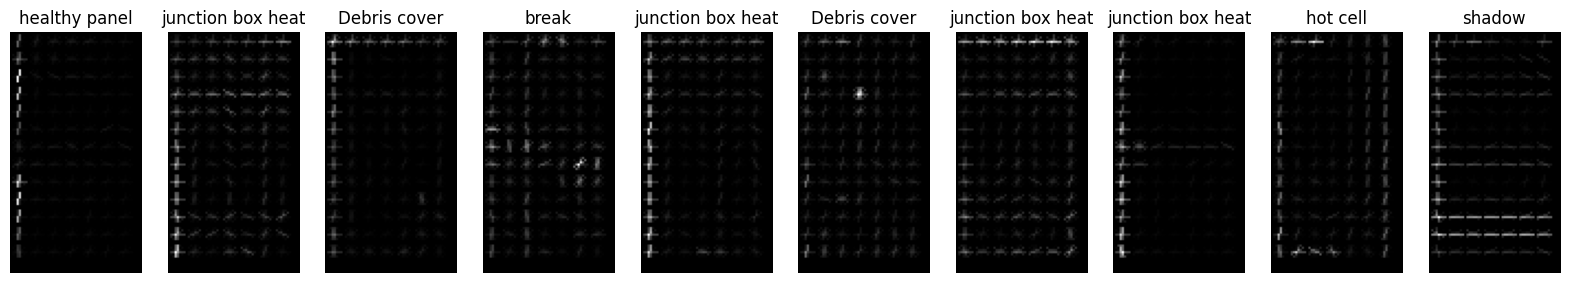

In [9]:
from skimage.feature import hog
import matplotlib.pyplot as plt

# Extraction HOG  des images
def extract_hog_features(images):
    hog_features = []
    hog_images = []
    for image in images:
        hog_feature,hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        hog_features.append(hog_feature)
        hog_images.append(hog_image)
    return np.array(hog_features),hog_images

# Extraction HOG des images d'entraînement et de test
X_train,hog_images_train = extract_hog_features(images_train)
X_test,hog_images_test = extract_hog_features(images_test)
y_train = labels_train
y_test = labels_test

print("Taille d'un vecteur HOG :", len(X_test[0]))

# Visualiser quelques images HOG de test
nums_image = np.random.randint(len(X_test), size=10)
hog_images_display = [hog_images_test[num] for num in nums_image]
labels_display = [y_test[num] for num in nums_image]
fig, axes = plt.subplots(1, 10, figsize=(20, 7))
for ax, hog_image, label in zip(axes.ravel(), hog_images_display, labels_display):
    ax.imshow(hog_image, cmap="gray")
    ax.set_title(label)
    ax.axis("off")
plt.show()

### Entraînement modèle SVM

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Grille de paramètres pour GridSearchCV
parametres = {
    'C':[0.1,1,10]
}

# Création du modèle avec cette grille de paramètres
svm = SVC(kernel="rbf", gamma="scale")
grid_model = GridSearchCV(svm, parametres)

# Entraînement du modèle
grid_model.fit(X_train, y_train)

# Meilleurs paramètres
print(grid_model.best_params_) 



{'C': 10}


### Evaluation SVM

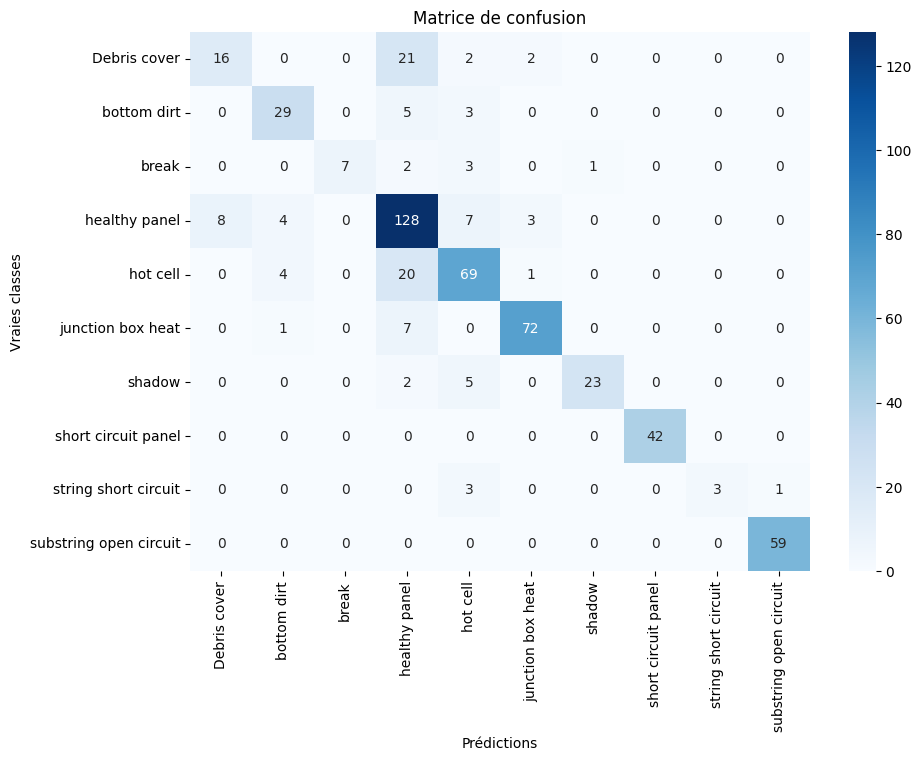

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = grid_model.predict(X_test)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de confusion")
plt.show()

In [12]:
from sklearn.metrics import classification_report

# Générer le rapport de classification
class_report = classification_report(y_test, y_pred)

# Afficher le rapport
print("Rapport de classification :\n", class_report)

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.67      0.39      0.49        41
           bottom dirt       0.76      0.78      0.77        37
                 break       1.00      0.54      0.70        13
         healthy panel       0.69      0.85      0.76       150
              hot cell       0.75      0.73      0.74        94
     junction box heat       0.92      0.90      0.91        80
                shadow       0.96      0.77      0.85        30
   short circuit panel       1.00      1.00      1.00        42
  string short circuit       1.00      0.43      0.60         7
substring open circuit       0.98      1.00      0.99        59

              accuracy                           0.81       553
             macro avg       0.87      0.74      0.78       553
          weighted avg       0.82      0.81      0.81       553



### Entraînement modèle KNN

In [19]:
# Grille de paramètres pour GridSearchCV
parametres = {
    'n_neighbors':np.arange(2,10)
}

# Création du modèle avec cette grille de paramètres
from sklearn import neighbors
knn =  neighbors.KNeighborsClassifier()
grid_model = GridSearchCV(knn, parametres)

# Entraînement du modèle
grid_model.fit(X_train, y_train)

# Meilleurs paramètres
print(grid_model.best_params_) 

{'n_neighbors': np.int64(9)}


### Evaluation KNN

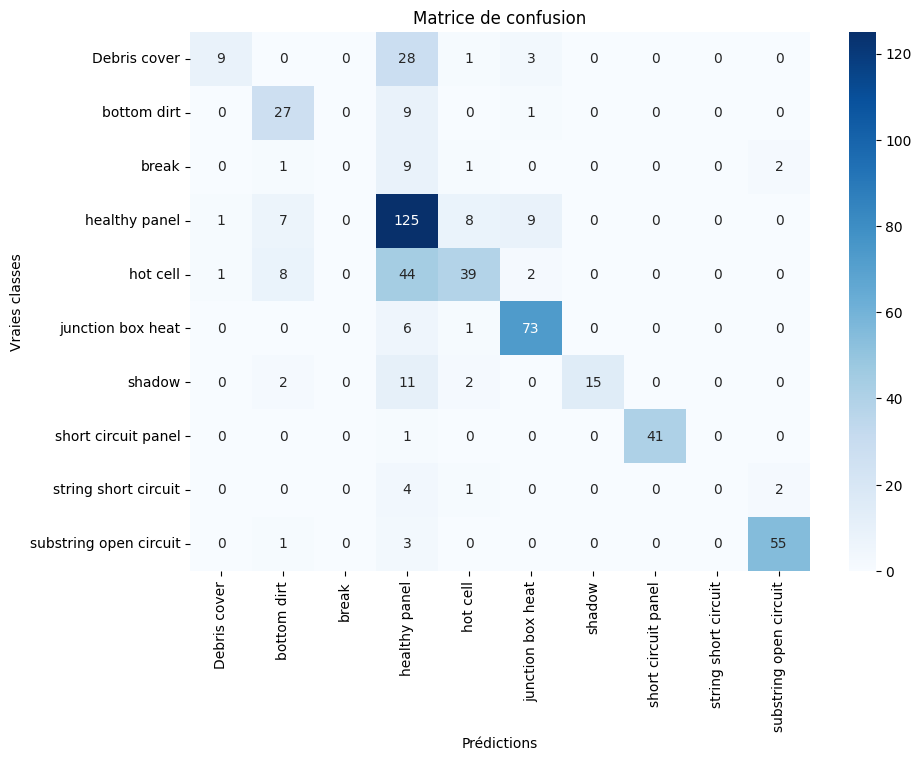

In [20]:
y_pred = grid_model.predict(X_test)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de confusion")
plt.show()

In [21]:
from sklearn.metrics import classification_report

# Générer le rapport de classification
class_report = classification_report(y_test, y_pred, target_names=np.unique(y_test))

# Afficher le rapport
print("Rapport de classification :\n", class_report)

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.82      0.22      0.35        41
           bottom dirt       0.59      0.73      0.65        37
                 break       0.00      0.00      0.00        13
         healthy panel       0.52      0.83      0.64       150
              hot cell       0.74      0.41      0.53        94
     junction box heat       0.83      0.91      0.87        80
                shadow       1.00      0.50      0.67        30
   short circuit panel       1.00      0.98      0.99        42
  string short circuit       0.00      0.00      0.00         7
substring open circuit       0.93      0.93      0.93        59

              accuracy                           0.69       553
             macro avg       0.64      0.55      0.56       553
          weighted avg       0.72      0.69      0.67       553



d:\Sources\PVF\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Sources\PVF\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Sources\PVF\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
